In [13]:
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
import tensorflow as tf
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import import_ipynb
from sklearn.model_selection import GroupShuffleSplit
import numpy_indexed as npi
from scipy import stats
from sklearn.metrics import make_scorer, accuracy_score, precision_score,recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import seaborn as sns
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D,Dropout,Flatten,MaxPooling2D, Input
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split

In [123]:
path = '/Users/deiry/ML/Voice_Recognition/data/mel-spectrograms_7500.hd5'

In [124]:
df = pd.read_hdf(path)
df.shape

(7500, 3)

In [125]:
df.tail()

,mel-spectrogram,speaker,word
7495,"[[825.86426, 823.86835, 823.74115, 823.8642, 8...",916,1
7496,"[[1321.0461, 1318.3152, 1318.8292, 1319.0348, ...",916,1
7497,"[[1288.8186, 1288.5488, 1288.7296, 1288.8041, ...",916,1
7498,"[[1390.5499, 1390.8105, 1390.8024, 1390.8684, ...",916,1
7499,"[[1064.0765, 1065.097, 1064.8335, 1064.9655, 1...",916,1


In [49]:
dfx = df[0:100]
dfx.shape

(100, 3)

In [126]:
test_size = 0.2

In [116]:
def buildX(X, input_shape):    
    Xreshape = np.zeros(input_shape)
    c = 0
    for i in X:
        i = np.expand_dims(i, axis=3)
        Xreshape[c,:,:,:]=i
        c =c +1
    return Xreshape


def reshapeDataset(df):
    (width, heigth) = df['mel-spectrogram'][0].shape
    channel = 1
    shape_X = (len(df),width, heigth, channel)
    input_shape_cnn = (width, heigth, channel)
    print("Shape final ",shape_X)
    X = buildX(df['mel-spectrogram'].values, shape_X)
    print("Input CNN ",input_shape_cnn)
    y = df.word.values
    groups = df.speaker.values
    
    return X,y,groups, input_shape_cnn

def splitDatasetbyGroup(X,Y, groups, test_size):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
    gss.get_n_splits()

    for train_index, test_index in gss.split(X, Y, groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        groups_train = groups[train_index]
        groups_test =groups[test_index]
        
    return X_train, X_test, Y_train, Y_test, groups_train, groups_test
    
def buildCNN(input_shape, num_classes):
    model = Sequential()
    img= Input(shape=input_shape)
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    validity = model(img)
    Model(img, validity)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    print(model.summary())
    return model



In [127]:
X,y,groups, input_shape = reshapeDataset(df)

Shape final  (7500, 128, 44, 1)
Input CNN  (128, 44, 1)


In [128]:
X_train, X_test, Y_train, y_test, groups_train, groups_test = splitDatasetbyGroup(X,y, groups, test_size)
y_trainOHE = utils.to_categorical(Y_train)
num_classes = y_trainOHE.shape[1]

In [129]:
print(X_train.shape, y_trainOHE.shape)

(5962, 128, 44, 1) (5962, 5)


In [130]:
model = buildCNN(input_shape, num_classes)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 124, 40, 32)       832       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 122, 38, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 19, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 74176)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               9494656   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 9,514,629
Trainable params: 9,514,629
Non-trainable params: 0
____________________________________________

In [131]:
history = model.fit(X_train, y_trainOHE, epochs=100, batch_size=10, validation_split=0.20, verbose=1)

Train on 4769 samples, validate on 1193 samples
Epoch 1/100
4769/4769 [==============================] - 104s 22ms/sample - loss: 1.2870 - accuracy: 0.6966 - val_loss: 5.8588 - val_accuracy: 0.0000e+00
Epoch 2/100
4769/4769 [==============================] - 120s 25ms/sample - loss: 0.2555 - accuracy: 0.9088 - val_loss: 6.1052 - val_accuracy: 0.0134
Epoch 3/100
4769/4769 [==============================] - 94s 20ms/sample - loss: 0.0987 - accuracy: 0.9652 - val_loss: 7.7443 - val_accuracy: 0.0050
Epoch 4/100
4769/4769 [==============================] - 91s 19ms/sample - loss: 0.0831 - accuracy: 0.9755 - val_loss: 8.1367 - val_accuracy: 0.0151
Epoch 5/100
4769/4769 [==============================] - 88s 18ms/sample - loss: 0.0574 - accuracy: 0.9818 - val_loss: 9.3786 - val_accuracy: 0.0369
Epoch 6/100
4769/4769 [==============================] - 78s 16ms/sample - loss: 0.0444 - accuracy: 0.9857 - val_loss: 8.7895 - val_accuracy: 0.0260
Epoch 7/100
4769/4769 [=============================

4769/4769 [==============================] - 77s 16ms/sample - loss: 5.3243e-09 - accuracy: 1.0000 - val_loss: 31.4732 - val_accuracy: 0.0092
Epoch 55/100
4769/4769 [==============================] - 77s 16ms/sample - loss: 4.1994e-09 - accuracy: 1.0000 - val_loss: 31.7007 - val_accuracy: 0.0092
Epoch 56/100
4769/4769 [==============================] - 78s 16ms/sample - loss: 3.3996e-09 - accuracy: 1.0000 - val_loss: 31.8019 - val_accuracy: 0.0101
Epoch 57/100
4769/4769 [==============================] - 78s 16ms/sample - loss: 2.5997e-09 - accuracy: 1.0000 - val_loss: 31.8497 - val_accuracy: 0.0109
Epoch 58/100
4769/4769 [==============================] - 78s 16ms/sample - loss: 2.0747e-09 - accuracy: 1.0000 - val_loss: 31.9572 - val_accuracy: 0.0101
Epoch 59/100
4769/4769 [==============================] - 78s 16ms/sample - loss: 1.5498e-09 - accuracy: 1.0000 - val_loss: 31.8194 - val_accuracy: 0.0109
Epoch 60/100
4769/4769 [==============================] - 79s 16ms/sample - loss: 1

In [132]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


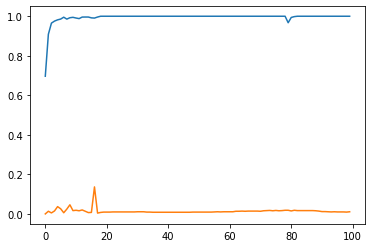

In [133]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [134]:
X_test.shape

(1538, 128, 44, 1)

In [135]:
y_test.shape

(1538,)

In [136]:
y_test = utils.to_categorical(y_test)

In [137]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=10)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test[:3])
print('predictions shape:', predictions.shape)


# Evaluate on test data
1538/1538 [==============================] - 6s 4ms/sample - loss: 6.4503 - accuracy: 0.7035
test loss, test acc: [6.450290562378315, 0.70351106]

# Generate predictions for 3 samples
predictions shape: (3, 5)
